This notebook creates the quantum circuits to simulate Pauli channels and performs quantum tomography on IBM's quantum computers to calculate the fidelity of the simulation. 

First of all, we import some libraries and functions we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans



#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


# 1. Pauli Channels

As described in the text, one qubit Pauli channels are operations $\varepsilon$ applied to a density matrix $\rho$ that have the form:

$$ \varepsilon(\rho) = k_0 \rho + k_1 \sigma_1 \rho \sigma_1 + k_2 \sigma_2 \rho \sigma_2  + k_3 \sigma_3 \rho \sigma_3,$$

with $k_i \geq 0$ and $\sum_i k_i = 1$. This is the Kraus form of a Pauli channel, but they can also be understood geometrically by finding the effect of a Pauli channel on the components $r_1, r_2, r_3$ of a density matrix when written as $\rho = \frac{1}{2} (I + \sum_{i=1}^3 r_i \sigma_i )$. In this interpration, the effect of a Pauli channel is to multiply each entry $r_i$ by a multiplier $\tau_i$:

$$ r_i \rightarrow \tau_i r_i,$$

with $\tau_1 = k_0+k_1-k_2-k_3\;,\; \tau_2 = k_0-k_1+k_2-k_3\;,\; \tau_3 = k_0-k_1-k_2+k_3$. The numbers $\tau_i$ have to satisfy the following conditions for the channel to be valid:

$$1+ \tau_i - \tau_j - \tau_k \geq 0 \;\; \text{for $i,j,k$ different numbers in $\{1,2,3\}$}, \\
1+\tau_1+\tau_2+\tau_3 \geq 0.$$

These inequalities define a tetrahedron in the space $(\tau_1,\tau_2,\tau_3)$ with vertices $(1,1,1), (1,1,-1), (1,-1,1), (-1,1,1)$.

### 1.1 Create lists of one-qubit Pauli channels

Here we define some functions to create sets of points inside a tetrahedron, which will be the Pauli channels we will simulate. 

In [2]:
def create_points_lattice(l):
    '''Creates a lattice of lxlxl points inside the cube 
    [-1,1] x [-1,1] x [-1,1] and then only keeps the lattice points 
    that are inside the tetrahedron of pauli channels.
    
    Args: 
        l (int): number of points in each axis of the lattice.
        
    Returns:
        set_points (list): The list of lattice points (tau1,tau2,tau3) 
        inside the tetrahedron.'''
    
    set_points=[]

    #We create the points in the lattice.
    tau1s = np.linspace(-1,1,l)
    tau2s = np.linspace(-1,1,l)
    tau3s = np.linspace(-1,1,l)

    #We will iterate over the lattice points.
    for taus in itertools.product(tau1s,tau2s,tau3s):
        #Check if each point is inside the tetrahedron, and add it to set_points.
        if np.around(1+taus[0]-taus[1]-taus[2],8)<0:
            continue
        if np.around(1+taus[1]-taus[2]-taus[0],8)<0:
            continue
        if np.around(1+taus[2]-taus[1]-taus[0],8)<0:
            continue
        if np.around(1+taus[0]+taus[1]+taus[2],8)<0:
            continue
            
        else:
            #If the point is inside the tetrahedron, we add it to set_points.
            set_points.append(taus)
    return(set_points)


def create_points_z_cut(l,tau3):
    '''Creates a set of points just as the previous function but
    now we only keep a cut with a certain value of tau3.
    
    Args: 
        l (int): number of points in each axis of the lattice.
        tau3 (float): The value of tau3 where we will make the cut of the
        tetrahedron.
    
    Returns: 
        set_points (list): returns the list of lattice points (tau1,tau2,tau3) in
        the tetrahedron and with the given value of tau3.'''
    
    set_points=[]

    #We create the lattice points for tau_1, tau_2.
    tau1s = np.linspace(-1,1,l)
    tau2s = np.linspace(-1,1,l)

    #Iterate over the points (tau_1, tau_2, tau3).
    for taus in itertools.product(tau1s,tau2s):
        
        taus = [taus[0],taus[1],tau3]
        #Check if the point is inside the tetrahedron and add it to the set.
        if np.around(1+taus[0]-taus[1]-taus[2],8)<0:
            continue
        if np.around(1+taus[1]-taus[2]-taus[0],8)<0:
            continue
        if np.around(1+taus[2]-taus[1]-taus[0],8)<0:
            continue
        if np.around(1+taus[0]+taus[1]+taus[2],8)<0:
            continue
            
        else:
            set_points.append(taus)
    return(set_points)



### 1.2 Circuit for a Pauli channel

As described in the text, a Pauli channel defined by $k_0, k_1, k_2, k_3$ can be implemented on a qubit $q_0$ using the following circuit:
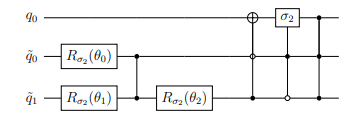

with $$\theta_0 = \arg(\sqrt{k_0}+i \sqrt{k_1}) - \arg(\sqrt{k_2} + i \sqrt{k_3}), \\
\theta_1 = 2 \arccos (\sqrt{k_0+k_1}), \\
\theta_2 = \arg(\sqrt{k_0}+i \sqrt{k_1}) + \arg(\sqrt{k_2} + i \sqrt{k_3}).
$$



In [3]:

def taus_to_k(taus):
    '''Converts the taus of a Pauli channel to the ks that
    define that same Pauli channel.
    
    Args:
        taus (list): A list [tau1,tau2,tau3] indicating a point in the
        tetrahedron of Pauli channels.
        
    Returns:
        ks (list): Returns the list [k0,k1,k2,k3] that represents the same 
        Pauli channel but using the Kraus representation.
        '''
    
    tau1,tau2,tau3 = taus
    k1 =  np.around(1/4*(1+tau1-tau2-tau3),8)
    k2 = np.around(1/4*(1-tau1+tau2-tau3),8)
    k3 = np.around(1/4*(1-tau1-tau2+tau3),8)
    k0 = np.around(1-k1-k2-k3,8)
    return([k0,k1,k2,k3])


def ks_to_circuit(ks):
    '''Given the values [k0,k1,k2,k3] that define a Pauli channel,
    we construct the quantum circuit to simulate it.
    
    Args: 
        ks (list): List [k0,k1,k2,k3] that represents a Pauli channel using the Kraus representation.
        
    Returns:
        circ (QuantumCircuit): Returns the quantum circuit that simulates the
        Pauli channel defined by the ks. The circuit has three qubits, the principal
        qubit and two ancilla.
    '''
    
    
    k0,k1,k2,k3 = ks
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1)) - np.angle(np.sqrt(k2)+1j*np.sqrt(k3))
    theta1 = 2*np.arccos(np.sqrt(k0+k1))
    theta2 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1)) + np.angle(np.sqrt(k2)+1j*np.sqrt(k3))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(3, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,1)
    circ.ry(theta0,2)
    circ.cz(1,2)
    circ.ry(theta2,2)
    
    #Add the controlled gates.
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)
    

def taus_to_circuit(taus):
    '''Create the quantum circuit of a Pauli channel starting from the taus.
    
    Args:
        taus (list): A list [tau1,tau2,tau3] indicating the point in the
        tetrahedron of Pauli channels.
        
    Returns:
        circuit (QuantumCircuit): Returns the quantum circuit that simulates the
        Pauli channel defined by the taus. The circuit has three qubits, the principal
        qubit and two ancilla.
    '''
    return(ks_to_circuit(taus_to_k(taus)))




In [4]:
def create_circuits(set_points):
    '''Create all the circuits for quantum process tomography (qpt)
    for a set of points in the tetrahedron of Pauli channels.
    
    Args:
        set_points (list): A list of points [tau1,tau2,tau3] representing
        Pauli channels.
        
    Returns:
        Circuits (list of QuantumCircuits): The circuits used to implement
        quantum process tomography for each Pauli channel. Each Pauli channel
        requires 12 circuits for quantum process tomography, so the
        total number of circuits will be 12*len(set_points).'''
    
        
    circuits = []
    # For each Pauli channel in set_points, we create the circuit
    # to simulate it and the circuits for quantum process tomography.
    for taus in set_points:
        
        # We create the circuit for this channel.
        circ = taus_to_circuit(taus)
        
        # We create the 12 circuits for quantum process tomography on the first circuit.
        circ_qpt = library.ProcessTomography(circ, physical_qubits=[0],
                                    measurement_indices=[0])
        
        # We add these circuits to the list of circuits.
        # Each Pauli channel requires 12 circuits for qpt.
        for c in circ_qpt.circuits():
            circuits.append(c)
    
    return(circuits)



# 2. Running the Circuits

Now we define the functions to run the circuits on one of ibm's quantum computers and save the results for each of the Pauli channels.

First we load the ibmq account and log in. The steps necessary to create said account is  https://github.com/Qiskit/qiskit-ibmq-provider .


In [6]:
from qiskit import IBMQ

# To save an account, we use the following line of code:
#### UNCOMMENT: IBMQ.save_account('MY_API_TOKEN') 
# The API_Token can be found in https://quantum-computing.ibm.com/account .

#Then, we load the account and get the provider.
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2023-07-10 09:33:54,954: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
import os

#A function that will be necessary later:
def take_element(dic,key):
    '''Function to take an element from a dictionary without
    having an error if the element does not exist, and returning
    a 0 in such case.
    
    Args: 
        dic (dictionary): A dictionary with keys and values.
        key (string): A key which may be or not in dic.
        
    Returns:
        The value of the key in dic if it exists, if not, returns 0.
    '''
    
    if key in dic:
        return(dic[key])
    else:
        return(0)

def run_circuits(computer,circuits,directory,file_name):
    '''Function to run the circuits in the list "circuits" in the 
    quantum computer and  save the results in a csv file.
    
    Args: 
        computer (str): Name of the IBM quantum computer we will use.
        
        circuits (list): List of circuits to send to the quantum computer.
        
        directory (str): Directory where we will save the results.
        
        file_name (str): Name of the file where we will save the results (.csv).
    Returns:
        Writes the results of all the circuits, that is, the number of times
        the computer measured a 1 or a 0 out of the 20,000 repetitions for
        each circuit. These results are written in a csv file.
        '''
    
    # We create the directory.    
    if os.path.exists(directory) == False:
        os.mkdir(directory)
    
    
    #csv file where we will save the binary results of the implementation in the quantum computer.
    file = directory+"/"+ file_name + '.csv'
    
    
    #Write the header (0,1) for the binary results that qiskit returns.
    with open(file,"a") as f:
        f.write("0,1")
        f.flush()

    #We can only send at most batcehs of 100 circuits to ibm, so we count
    #how many batches we will need to send in "repetitions".
    repetitions = len(circuits)//100
    
    results = []
    qcomp=  provider.get_backend(computer)

    
    #We iterate over the batches of circuits we will send.
    for j in range(repetitions):
        
        #Send the j-th batch of circuits to the quantum computer and implement 20000 times.
        circs = circuits[j*100:(j+1)*100]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        job_monitor(job)

        #Get the counts of the circuits we implemented.
        res = job.result().get_counts()
        print("Finished")
        
        #And add the counts to the csv file.
        with open(file,"a") as f:
            for res_i in res:
                data = [take_element(res_i,'0'),take_element(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                f.flush()
                
                results.append(res_i)
            
    #We implement the remaining circuits that are not in any of the batches
    # in the case that the amount of circuits is not a multiple of 100.
    if len(circuits) != 100*repetitions:
        circs=circuits[100*repetitions:]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        job_monitor(job)
        
        res = job.result().get_counts()
        
        with open(file,"a") as f:
            for res_i in res:
                data = [take_element(res_i,'0'),take_element(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                
                results.append(res_i)
                f.flush()
    return(results)        


# 3. Calculate Fidelity

### 3.1 Theoretical channel

We first define the funtions to calculate the theoretical Choi matrix of any Pauli channel.



In [8]:
def choi_theoretical(taus):
    '''For some values of taus describing a Pauli channel, this function
    returns the choi matrix of said channel.
    
    Args:
        taus (list): The list of taus [tau1,tau2,tau3] that defines a Pauli channel.
    
    Returns:
        mat_choi (qi.choi): The choi matrix of the channel.
    '''

    
    #First we convert the taus to the ks that describe the channel.
    k0,k1,k2,k3 = taus_to_k(taus)
    
    #We can write the Kraus representation of the channel, using that the 
    # Kraus operators are \sqrt{k_i} \sigma_i with \sigma_i the ith Pauli matrix.
    
    k = Kraus([np.sqrt(k0)*I,np.sqrt(k1)*X,
                               np.sqrt(k2)*Y,np.sqrt(k3)*Z])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))

### 3.2 Simulated Channel

We define the functions to calculate the Choi matrix obtained from the quantum process tomography of a given circuit.

The Choi matrix is defined as

$$ \Lambda = \sum_{i,j=0}^1 |i\rangle \langle j| \otimes \varepsilon (|i\rangle \langle j|), $$

with $\varepsilon$ the channel implemented by the circuit.

To calculate it, we need to know the effect of the circuit on four different initial states for the principal qubit. 

These inital states will be $|0\rangle \langle 0|,\; |1\rangle \langle 1|,\; |+\rangle \langle + |, |R\rangle \langle R|$, with $|+\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle),$ and $|R\rangle = \frac{1}{\sqrt{2}} (|0\rangle + i |1 \rangle )$. The results of applying the circuit to these initial states are $\varepsilon(|0\rangle \langle 0|), \; \varepsilon(|1\rangle \langle 1|), \; \varepsilon(|+\rangle \langle +|), \; \varepsilon(|R\rangle \langle R|)$, which we call respectively erho0, erho1, erhoplus and erhoR. 

Once we have these resulting density matrices, we can calculate the Choi matrix by using linearity of $\varepsilon$ and noting that $|0\rangle \langle 1| = |+\rangle\langle +| + i |R\rangle \langle R| + \frac{1+i}{2} |0\rangle \langle 0| - \frac{1+i}{2} |1\rangle \langle 1|$ and that $|1\rangle\langle 0 | = |+\rangle\langle +| - i |R\rangle \langle R| + \frac{1-i}{2} |0\rangle \langle 0| - \frac{1-i}{2} |1\rangle \langle 1|$.

Therefore, the problem now is to determine the result of applying the circuit to the four initial states we chose. To do it, we simply construct said initial state, apply the circuit and then apply quantum state tomography to the result. Quantum state tomography consists on measuring the resulting state in the three bases (the $X$, $Y$ and $Z$ bases). After repeating this many times and counting the amount of $0$s and $1$s obtained for each basis, we can get an approximation for the mean values  $\langle X \rangle$, $\langle Y \rangle$ and $\langle Z \rangle$ and then construct the density matrix as $\rho = \dfrac{1}{2} \left(I+\langle X \rangle X + \langle Y \rangle Y + \langle Z \rangle Z \right)$.

In [9]:
def rho_final(z1,z0,x1,x0,y1,y0):
    '''Given the results of a circuit measured on the three Pauli bases,
    we calculate the density matrix of the final state created by the circuit.
    
    Args:
        z1 (int): Number of 1s obtained by measuring in the Z basis.
        z0 (int): Number of 0s obtained by measuring in the Z basis.    
        x1 (int): Number of 1s obtained by measuring in the X basis.
        x0 (int): Number of 0s obtained by measuring in the X basis.
        y1 (int): Number of 1s obtained by measuring in the Y basis.
        y0 (int): Number of 0s obtained by measuring in the Y basis.
        
    Results:
        rho (array): The density matrix of the result of the circuit.
    '''
    
    # total = x1+x0 is the total number of repetitions of the circuit.
    total = x1+x0
    
    #meanz is the mean value of Z. Since Z has value 1 in the state |0> and
    # value -1 in |1>, the mean value of Z is the proportion of |0> measured
    # multiplied by 1 plus the proportion of |1> measured multiplied by -1,
    # that is (z0/total)*1 + (z1/total)*(-1). The same with X and Y.
    meanx = (x0/total) - (x1/total)
    meany = (y0/total) - (y1/total)
    meanz = (z0/total) - (z1/total)
    #Construct rho.
    rho = (I+meanx*X+meany*Y+meanz*Z)/2
    return(np.array(rho))


    
def choi_from_results(res):
    '''
    Given the binary results of the Quantum Process Tomography, construct
    the Choi matrix of the process.
    
    Args:
        res (list): list of dictionaries with the results of the 12 circuits of qpt.
    
    Return:
        choi (qi.choi): The choi matrix constructed from qpt.
    
    '''
    
    #The first 3 circuits of qpt corresponds to an initial state of the
    #principal qubit of |0> and then measuring the final state in the three bases
    #Z, X, Y. With the results of said circuits, we construct the final density matrix
    # after passing through the circuit using the function rho_final.
    #We do the same for the following circuits, which have initial state |1>,
    # and the next, with initial state |+> and finally the last three, with 
    #initial state |R>.
    erho0 = rho_final(take_element(res[0],'1'),take_element(res[0],'0'),
                      take_element(res[1],'1'),take_element(res[1],'0'),
                    take_element(res[2],'1'),take_element(res[2],'0'))
    
    erho1 = rho_final(take_element(res[3],'1'),take_element(res[3],'0'),
                      take_element(res[4],'1'),take_element(res[4],'0'),
                    take_element(res[5],'1'),take_element(res[5],'0'))
    
    erhoplus = rho_final(take_element(res[6],'1'),take_element(res[6],'0'),
                      take_element(res[7],'1'),take_element(res[7],'0'),
                    take_element(res[8],'1'),take_element(res[8],'0'))
    
    erhoR = rho_final(take_element(res[9],'1'),take_element(res[9],'0'),
                      take_element(res[10],'1'),take_element(res[10],'0'),
                    take_element(res[11],'1'),take_element(res[11],'0'))
    
    
    #Knowing the final density matrix of these 4 initial states, we
    #can calculate the Choi matrix as \sum_{i,j} |i><j| \otimes \eps(|i><j|)
    #with \eps the channel implemented by the circuit
    #\eps(|i><j|) can be calculated from linear combinations of erho0, erho1, erhomas, erhoR.
    
    
    choi = np.kron(np.array([[1,0],[0,0]]),erho0)
    choi+= np.kron(np.array([[0,1],[0,0]]),
    erhoplus+1j*erhoR-(1+1j)/2*erho0-(1+1j)/2*erho1)
    
    choi+= np.kron(np.array([[0,0],[1,0]]),
            erhoplus-1j*erhoR-(1-1j)/2*erho1-(1-1j)/2*erho0)
    
    choi+= np.kron(np.array([[0,0],[0,1]]),erho1)
    return(qi.Choi(choi))

### 3.3 Fidelities

We will now define the functions to calculate the diamond fidelity as defined in the main text, which is

$$f = 1 - \dfrac{1}{2} ||\varepsilon_I - \varepsilon_T ||_{\diamond},$$

with  $\varepsilon_I$ the implemented channel in the quantum computer, $\varepsilon_T$ the theoretical channel and $|| \cdot ||_{\diamond}$ the diamond norm.

In [10]:
import pandas as pd

def create_dict(df):
    '''Create a dictionary from an array of results.'''
    d = []
    lista = np.array(df)
    for a in lista:
        d.append({'0': a[0], '1': a[1]})
    return(d)

        
            
def diam_fidelity(list_,direction,file_name):
    '''Given the direction of the file with the binary results and
    the list of channels the results come from, this function creates
    a file with the fidelity of each channel.
    
    Args:
        direction (str): The address of the directory where the binary results are (.csv).
        
        list_ (list): List of channels of the form [tau1, tau2, tau3] that
        correspond with the binary results.
        
        file_name (str): Name of file where we will save the fidelities .
    '''
    
    #We read the binary results and create the address for the file with fidelities.
    results_bin = pd.read_csv(direction)
    strin = direction[0:direction.rfind('/')+1]+file_name + ".csv"
    
    #Open the fidelity file and write a header.
    with open(strin,"w") as f:
        f.write("tau1,tau2,tau3,fidelity")
    
    #Go through the list.
    for i, lam in enumerate(list_):
        # Get the results of qpt the ith channel only.
        resul_i = results_bin.iloc[12*i:12*i+12]
        #create the dictionary of said result.
        d = create_dict(resul_i)
        
        #Create the theoretical and simulated Choi matrices. 
        choi_theo = choi_theoretical(lam)
        choi_compu = choi_from_results(d)
        
        dis =qi.diamond_norm(qi.Choi(choi_compu)-choi_theo)
        
        #1-0.5*dis is the fidelity.
        data = (lam[0],lam[1],lam[2],1-0.5*dis)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))

   


# 4. Drawings

We now define the functions to create drawings of the fidelities for Pauli channels shown in the tetrahedron. With this, we can make these graphs:

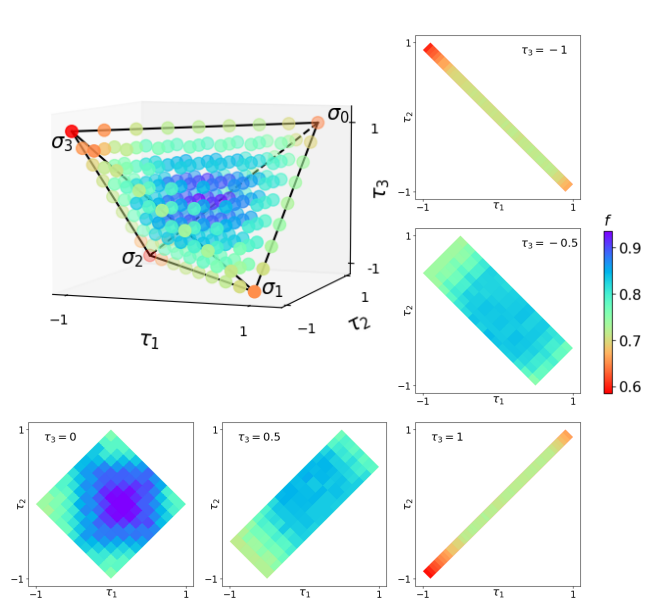

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from matplotlib import cm


def graph(document):
    '''Graph the fidelities of Pauli channels in the tetrahedron.
    
    Args:
        document (string): File address of the document with the fidelities we want to graph.
    '''
    
    #Open the file.
    file = open(document)
    csvreader = csv.reader(file)
    
    #Create the figure.
    fig = plt.figure()
    ax = plt.axes(projection='3d')
        
    #Draw the lines of the tetrahedron.
    ax.plot([1,1],[1,-1],[1,-1],'k')
    ax.plot([1,-1],[1,1],[1,-1],'k--')
    ax.plot([1,-1],[1,-1],[1,1],'k')
    ax.plot([-1,1],[1,-1],[-1,-1],'k--')
    ax.plot([-1,-1],[1,-1],[-1,1],'k--')
    ax.plot([1,-1],[-1,-1],[-1,1],'k')

    #Draw the vertices of the tetrahedron.
    ax.text(1,1,1,'$\sigma_0$',size=15)
    ax.text(1,-1,-1,'$\sigma_1$',size=15)
    ax.text(-1,1,-1,'$\sigma_2$',size=15)
    ax.text(-1,-1,1,'$\sigma_3$',size=15)

    #Name the axes and write the ticks.
    ax.set_xlabel(r'$\tau_1$', fontsize=15)
    ax.set_ylabel(r'$\tau_2$',fontsize=15)
    plt.xticks([-1,0,1],fontsize=10)
    plt.yticks([-1,0,1],fontsize=10)
    ax.set_zticks([-1, 0, 1])
    ax.set_zticklabels([-1,0,1],fontsize=10)
    ax.set_zlabel(r'$\tau_3$', fontsize=15, rotation = 0)


    
    #xs,ys,zs contain the coordinates of points in the tetrahedron and
    #fid their fidelities.
    xs = []; ys = []; zs = []; fid= []
    
    #Read the file row by row.
    for row in csvreader:
        #With this line we jump the header row.
        if row[0] == 'tau1':
            continue
        
        #Append the x,y and z coordinates and the corresponding fidelity.
        xs.append(float(row[0]))
        ys.append(float(row[1]))
        zs.append(float(row[2]))
        fid.append(float(row[3]))
        
    
    #We set colors according to the fidelities.
    colors = cm.rainbow_r((np.array(fid)-min(fid))/(max(fid)-min(fid)))
    colmap = cm.ScalarMappable(cmap=cm.rainbow_r)
    colmap.set_array(fid)
    
    
    #We draw the points with said colors.
    yg = ax.scatter(xs, ys, zs, c=colors, marker='o',s=80)
    cb = fig.colorbar(colmap)
    cb.ax.tick_params(labelsize=15) 
    
    cb.ax.set_title("$p_{succ}$",fontsize=18)
    ax.view_init(6,290)

    
    plt.show()



In [12]:
import matplotlib.transforms as mtransforms


from matplotlib import cm
                 

def do_plot(ax, Z, transform):
    im = ax.imshow(Z, interpolation='none',
                   origin='lower',
                   extent=[0, 1, 0, 1], clip_on=True,
                   cmap =cm.rainbow_r,
                  vmin=0,
                  vmax=1)

    trans_data = transform + ax.transData
    im.set_transform(trans_data)

    x1, x2, y1, y2 = im.get_extent()
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    

    
def transformation(x,y,tau3):
    res1 = x*(1-tau3) + y * (1+tau3) - 1
    res2 = x*(tau3-1) + y*(1+tau3) - tau3
    
    return(res1,res2)
    



def closest(px,py,xs,ys,point):
    mini = 1000
    for  i in range(len(xs)):
        punto = [xs[i],ys[i]]
        distancia = (px-xs[i])**2 + (py-ys[i])**2   
        
        if distancia < mini:
            mini = distancia
            mejor_i = i
    return(point[mejor_i][-1])



def plot_cut(file,tau3,ny,nx,mini,maxi):
    '''Plot a cut with constant value of tau3 of the fidelities of points
    in the tetrahedron.
    
    Args:
        file (str): The address of the file with the fidelities.
        tau3 (float): The value of tau3 where the cut is.
        ny (int): number of vertical divisions of the cut.
        nx (int): number of horizontal divisions of the cut.
        mini (float): minimum fidelity found in all the tetrahedron.
        maxi (float): maximum fidelity found in all the tetrahedron.'''
    
    #Read the file
    file = open(file)
    csvreader = csv.reader(file)

    #Define the arrays of points x,y,z.
    xs = []; ys = []; zs = []
    
    #Define the array point, with [tau1,tau2,tau3,color].
    point=[]

    
    for row in csvreader:
        #This line jumps the header.
        if row[0] == 'tau1':
            continue
        #Append the points
        xs.append(float(row[0]))
        ys.append(float(row[1]))
        zs.append(float(row[2]))
        
        
        #In the array point, we add [tau1, tau2, tau3, color]
        #with color being the fideility normalized so that the minimum
        #fidelity is 0 and the maximum is 1.
        point.append([float(row[0]),float(row[1]),float(row[2]),
                 (float(row[3])-mini)/(maxi-mini)])
        
        
    # If tau3 is too high or too small, make it 0.9 for the drawing to not
    # be a  line with very smal width.
    t3 = tau3
    if t3 > 0.9:
        t3 = 0.9
    if t3 <-0.9:
        t3 = -0.9
        
    #Create a matrix to put the information of the colors.
    mat = np.zeros((nx,ny))


    for i in range(nx):
        for j in range(ny):
            px,py = transformation(i/nx, j/ny,t3)
        
            mat[i][j] = closest(px,py,xs,ys,point)
        

    fig, ax = plt.subplots(1,1)
    do_plot(ax, mat, mtransforms.Affine2D().scale(np.sqrt(2)*(t3+1),np.sqrt(2)*(t3-1)).rotate_deg(45).translate(-1,-t3))

    plt.xticks([-1,1],fontsize=15)
    plt.yticks([-1,1],fontsize=15)

    plt.xlabel(r"$\tau_1$",fontsize=18)
    plt.ylabel(r"$\tau_2$",fontsize=18)
    ax.xaxis.set_label_coords(0.5, -.01)
    ax.yaxis.set_label_coords(-0.01, 0.5)


    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
    plt.text(-0.9,0.85,r'$\tau_3 = $' + str(tau3) ,fontsize=18)

    plt.show()

# Everything put together

Now we put everything together and call the functions.

First, we do it for a lattice of points in the tetrahedron.

In [17]:
# 1. We create a lattice of points in the tetrahedron.

channels = create_points_lattice(9)
print("Amount of channels: ", len(channels))
channels

Amount of channels:  249


[(-1.0, -1.0, 1.0),
 (-1.0, -0.75, 0.75),
 (-1.0, -0.5, 0.5),
 (-1.0, -0.25, 0.25),
 (-1.0, 0.0, 0.0),
 (-1.0, 0.25, -0.25),
 (-1.0, 0.5, -0.5),
 (-1.0, 0.75, -0.75),
 (-1.0, 1.0, -1.0),
 (-0.75, -1.0, 0.75),
 (-0.75, -0.75, 0.5),
 (-0.75, -0.75, 0.75),
 (-0.75, -0.75, 1.0),
 (-0.75, -0.5, 0.25),
 (-0.75, -0.5, 0.5),
 (-0.75, -0.5, 0.75),
 (-0.75, -0.25, 0.0),
 (-0.75, -0.25, 0.25),
 (-0.75, -0.25, 0.5),
 (-0.75, 0.0, -0.25),
 (-0.75, 0.0, 0.0),
 (-0.75, 0.0, 0.25),
 (-0.75, 0.25, -0.5),
 (-0.75, 0.25, -0.25),
 (-0.75, 0.25, 0.0),
 (-0.75, 0.5, -0.75),
 (-0.75, 0.5, -0.5),
 (-0.75, 0.5, -0.25),
 (-0.75, 0.75, -1.0),
 (-0.75, 0.75, -0.75),
 (-0.75, 0.75, -0.5),
 (-0.75, 1.0, -0.75),
 (-0.5, -1.0, 0.5),
 (-0.5, -0.75, 0.25),
 (-0.5, -0.75, 0.5),
 (-0.5, -0.75, 0.75),
 (-0.5, -0.5, 0.0),
 (-0.5, -0.5, 0.25),
 (-0.5, -0.5, 0.5),
 (-0.5, -0.5, 0.75),
 (-0.5, -0.5, 1.0),
 (-0.5, -0.25, -0.25),
 (-0.5, -0.25, 0.0),
 (-0.5, -0.25, 0.25),
 (-0.5, -0.25, 0.5),
 (-0.5, -0.25, 0.75),
 (-0.5, 0.0, 

In [18]:
# 2. We create the circuits for these points.

circuits = create_circuits(channels)
print("Amount of circuits: ", len(circuits))
circuits

Amount of circuits:  2988


 ...]

Notice that the amount of circuits is 12 times the amoung of channels, since each channel requires 12 circuits for Quantum Process Tomography (4 different initial states and each one measured in the 3 bases of X,Y,Z).

In [19]:
#3. We run the circuits on one of IBM's quantum computers and this creates
# a file with the results. The file has the same number of rows as circuits
# in the list of circuits and each row gives the amount of 1s and 0s measured.

computer = "ibmq_lima"
run_circuits(computer,circuits,directory="Simulation-imbq_lima",file_name='binary-results')

Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully r

[{'0': 15725, '1': 4275},
 {'1': 9834, '0': 10166},
 {'1': 9787, '0': 10213},
 {'1': 14437, '0': 5563},
 {'0': 10278, '1': 9722},
 {'1': 9825, '0': 10175},
 {'1': 9304, '0': 10696},
 {'1': 13944, '0': 6056},
 {'0': 10176, '1': 9824},
 {'1': 9376, '0': 10624},
 {'1': 9926, '0': 10074},
 {'1': 14133, '0': 5867},
 {'0': 14543, '1': 5457},
 {'0': 10217, '1': 9783},
 {'0': 10253, '1': 9747},
 {'0': 6859, '1': 13141},
 {'0': 10116, '1': 9884},
 {'1': 9687, '0': 10313},
 {'0': 10752, '1': 9248},
 {'1': 14023, '0': 5977},
 {'0': 10131, '1': 9869},
 {'0': 10563, '1': 9437},
 {'0': 10132, '1': 9868},
 {'0': 7206, '1': 12794},
 {'0': 13251, '1': 6749},
 {'0': 10406, '1': 9594},
 {'0': 10045, '1': 9955},
 {'1': 12047, '0': 7953},
 {'0': 10138, '1': 9862},
 {'0': 10244, '1': 9756},
 {'1': 9334, '0': 10666},
 {'1': 14108, '0': 5892},
 {'0': 10232, '1': 9768},
 {'1': 9478, '0': 10522},
 {'0': 10152, '1': 9848},
 {'1': 11883, '0': 8117},
 {'0': 12014, '1': 7986},
 {'0': 10239, '1': 9761},
 {'0': 10190

In [20]:
#4. We now obtain the fidelities of the Pauli channels from the file with results.

#lattice_tetra is the set of Pauli channels,
#direction is the address where the file with the binary results is saved 
# and file is the name of the file with fidelities.
diam_fidelity(channels,direction="Simulation-imbq_lima/binary-results.csv",file_name="fidelities")

mini = min(np.array(pd.read_csv("Simulation-imbq_lima/fidelities.csv")['fidelity']))
maxi = max(np.array(pd.read_csv("Simulation-imbq_lima/fidelities.csv")['fidelity']))
print(mini,maxi)

0.5873106118751463 0.9473673405129064


C:\Users\tbasi\AppData\Local\Temp\ipykernel_5776\2643830477.py:72: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


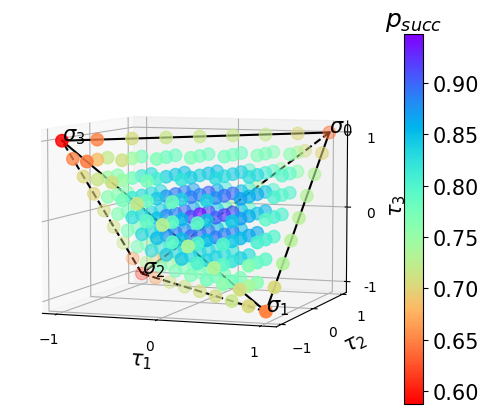

In [21]:
#5. Drawing the tetrahedron with the fidelities.

graph("Simulation-imbq_lima/fidelities.csv")

 We can also do it for one of the cuts of the tetrahedron. We will do it for tau3 = 0 in this case

In [22]:
# 1. We create an array of points with tau3 = 0 for example.

channels = create_points_z_cut(20,0)
print("Amount of channels: ", len(channels))
channels

Amount of channels:  180


[[-0.8947368421052632, -0.052631578947368474, 0],
 [-0.8947368421052632, 0.05263157894736836, 0],
 [-0.7894736842105263, -0.1578947368421053, 0],
 [-0.7894736842105263, -0.052631578947368474, 0],
 [-0.7894736842105263, 0.05263157894736836, 0],
 [-0.7894736842105263, 0.1578947368421053, 0],
 [-0.6842105263157895, -0.26315789473684215, 0],
 [-0.6842105263157895, -0.1578947368421053, 0],
 [-0.6842105263157895, -0.052631578947368474, 0],
 [-0.6842105263157895, 0.05263157894736836, 0],
 [-0.6842105263157895, 0.1578947368421053, 0],
 [-0.6842105263157895, 0.26315789473684204, 0],
 [-0.5789473684210527, -0.368421052631579, 0],
 [-0.5789473684210527, -0.26315789473684215, 0],
 [-0.5789473684210527, -0.1578947368421053, 0],
 [-0.5789473684210527, -0.052631578947368474, 0],
 [-0.5789473684210527, 0.05263157894736836, 0],
 [-0.5789473684210527, 0.1578947368421053, 0],
 [-0.5789473684210527, 0.26315789473684204, 0],
 [-0.5789473684210527, 0.36842105263157876, 0],
 [-0.4736842105263158, -0.47368421

In [23]:
# 2. We create the circuits for these points.

circuits = create_circuits(channels)
print("Amount of circuits: ", len(circuits))
circuits

Amount of circuits:  2160


 ...]

In [24]:
# 3. We run the circuits on one of IBM's quantum computers and this creates
# a file with the results. The file has the same number of rows as circuits
# in the list of circuits and each row gives the amount of 1s and 0s measured.

computer = "ibmq_lima"
run_circuits(computer,circuits,directory="Simulation-imbq_lima",file_name='binary-results-t3=0')

Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully r

[{'0': 10807, '1': 9193},
 {'0': 10248, '1': 9752},
 {'0': 10109, '1': 9891},
 {'1': 9472, '0': 10528},
 {'0': 10197, '1': 9803},
 {'0': 10139, '1': 9861},
 {'0': 10699, '1': 9301},
 {'1': 13615, '0': 6385},
 {'1': 9708, '0': 10292},
 {'0': 10547, '1': 9453},
 {'1': 9824, '0': 10176},
 {'0': 10220, '1': 9780},
 {'0': 10844, '1': 9156},
 {'0': 10198, '1': 9802},
 {'1': 9919, '0': 10081},
 {'0': 10258, '1': 9742},
 {'0': 10227, '1': 9773},
 {'1': 9831, '0': 10169},
 {'0': 10667, '1': 9333},
 {'1': 13572, '0': 6428},
 {'1': 9629, '0': 10371},
 {'1': 9248, '0': 10752},
 {'1': 9777, '0': 10223},
 {'1': 9240, '0': 10760},
 {'1': 9118, '0': 10882},
 {'0': 10253, '1': 9747},
 {'1': 9789, '0': 10211},
 {'1': 9523, '0': 10477},
 {'1': 9711, '0': 10289},
 {'0': 10201, '1': 9799},
 {'0': 10535, '1': 9465},
 {'1': 13181, '0': 6819},
 {'0': 10381, '1': 9619},
 {'0': 10687, '1': 9313},
 {'1': 9767, '0': 10233},
 {'0': 9664, '1': 10336},
 {'0': 10794, '1': 9206},
 {'0': 10112, '1': 9888},
 {'1': 9797,

In [25]:
# 4.  We now obtain the fidelities of the Pauli channels from the file with results.

#ibmq_lima_1 is the directory where the file with results is saved 
# and lattice_tetra is the list of Pauli channels.
diam_fidelity(channels,direction="Simulation-imbq_lima/binary-results-t3=0.csv",
              file_name="fidelities-t3=0")

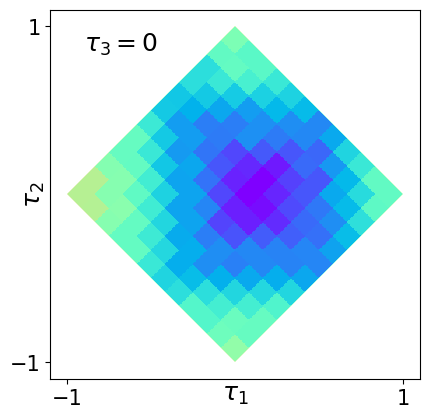

In [26]:
#5. Drawing the cut with the fidelities.

plot_cut("Simulation-imbq_lima/fidelities-t3=0.csv",0,12,12,mini,maxi)

In [27]:
# 1. We create an array of points with tau3 = 1 for example.

channels = create_points_z_cut(50,1)
print("Amount of channels: ", len(channels))
channels

Amount of channels:  50


[[-1.0, -1.0, 1],
 [-0.9591836734693877, -0.9591836734693877, 1],
 [-0.9183673469387755, -0.9183673469387755, 1],
 [-0.8775510204081632, -0.8775510204081632, 1],
 [-0.8367346938775511, -0.8367346938775511, 1],
 [-0.7959183673469388, -0.7959183673469388, 1],
 [-0.7551020408163265, -0.7551020408163265, 1],
 [-0.7142857142857143, -0.7142857142857143, 1],
 [-0.6734693877551021, -0.6734693877551021, 1],
 [-0.6326530612244898, -0.6326530612244898, 1],
 [-0.5918367346938775, -0.5918367346938775, 1],
 [-0.5510204081632654, -0.5510204081632654, 1],
 [-0.5102040816326531, -0.5102040816326531, 1],
 [-0.4693877551020409, -0.4693877551020409, 1],
 [-0.4285714285714286, -0.4285714285714286, 1],
 [-0.3877551020408164, -0.3877551020408164, 1],
 [-0.34693877551020413, -0.34693877551020413, 1],
 [-0.30612244897959184, -0.30612244897959184, 1],
 [-0.26530612244897966, -0.26530612244897966, 1],
 [-0.22448979591836737, -0.22448979591836737, 1],
 [-0.1836734693877552, -0.1836734693877552, 1],
 [-0.142857142

In [28]:
# 2. We create the circuits for these points.

circuits = create_circuits(channels)
print("Amount of circuits: ", len(circuits))
circuits

Amount of circuits:  600


In [29]:
# 3. We run the circuits on one of IBM's quantum computers and this creates
# a file with the results. The file has the same number of rows as circuits
# in the list of circuits and each row gives the amount of 1s and 0s measured.

computer = "ibmq_lima"
run_circuits(computer,circuits,directory="Simulation-imbq_lima",file_name='binary-results-t3=1')

Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished
Job Status: job has successfully run
Finished


[{'0': 15716, '1': 4284},
 {'0': 10187, '1': 9813},
 {'0': 10214, '1': 9786},
 {'1': 14492, '0': 5508},
 {'1': 9784, '0': 10216},
 {'1': 9849, '0': 10151},
 {'1': 9318, '0': 10682},
 {'0': 6190, '1': 13810},
 {'1': 9742, '0': 10258},
 {'0': 10492, '1': 9508},
 {'0': 10179, '1': 9821},
 {'0': 5906, '1': 14094},
 {'0': 15724, '1': 4276},
 {'1': 9641, '0': 10359},
 {'1': 9970, '0': 10030},
 {'1': 14395, '0': 5605},
 {'1': 9756, '0': 10244},
 {'1': 9753, '0': 10247},
 {'1': 9340, '0': 10660},
 {'0': 6421, '1': 13579},
 {'1': 9720, '0': 10280},
 {'0': 10789, '1': 9211},
 {'0': 9964, '1': 10036},
 {'1': 13820, '0': 6180},
 {'1': 4277, '0': 15723},
 {'1': 9916, '0': 10084},
 {'0': 10193, '1': 9807},
 {'1': 14286, '0': 5714},
 {'1': 9700, '0': 10300},
 {'0': 10301, '1': 9699},
 {'1': 9372, '0': 10628},
 {'1': 13549, '0': 6451},
 {'1': 9854, '0': 10146},
 {'1': 9234, '0': 10766},
 {'0': 10298, '1': 9702},
 {'0': 6278, '1': 13722},
 {'0': 15723, '1': 4277},
 {'1': 9894, '0': 10106},
 {'1': 9777,

In [31]:
# 4.  We now obtain the fidelities of the Pauli channels from the file with results.

#ibmq_lima_1 is the directory where the file with results is saved 
# and lattice_tetra is the list of Pauli channels.
diam_fidelity(channels,direction="Simulation-imbq_lima/binary-results-t3=1.csv",
              file_name="fidelities-t3=1")

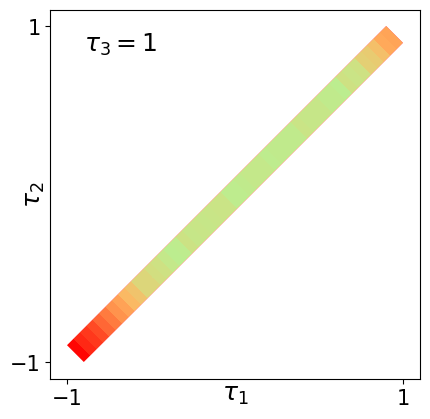

In [32]:
#5. Drawing the cut with the fidelities.

plot_cut("Simulation-imbq_lima/fidelities-t3=1.csv",1,50,1,mini,maxi)